# About
This notebook illustrates the calculation of a game specific "odd" interpreted as **how likely is the win of team A competing against team B?**.
***

# Preface
## Imports

In [42]:
import os
os.chdir("/home/jovyan/work")

from IPython.core.display import HTML
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
from sqlalchemy import text
from scipy.stats import beta
from scipy.integrate import quad

from src.plotting import plot_odds
from src.utils import calc_odds, enumerate_matches, get_connection

## Config

In [8]:
%matplotlib inline
sns.set()

HTML("""
<style>
.output_png{
text-align:center;
}
</style>
""")

***
# Get the raw team overview
In order to get started, a table containing **team_id**, **wins** and **losses** is needed:

In [9]:
df_wins_losses_per_team  = pd.read_sql(
    sql=text("""
    SELECT wins.season, wins.team_id, wins.wins, losses.losses
    FROM t_derived_wins_per_team_per_season wins
    JOIN t_derived_losses_per_team_per_season losses
    ON wins.season = losses.season
    AND wins.team_id = losses.team_id
    LIMIT 5
    """),
    con=get_connection()
)
df_wins_losses_per_team

,season,team_id,wins,losses
0,1985,1102,5,19
1,1985,1103,9,14
2,1985,1104,21,9
3,1985,1106,10,14
4,1985,1108,19,6


# Calculate every possible matchup

The next step is to calculate every possible matchup. Since the matchups are symmetric (the match "A vs. B" is considered the same as "B vs. A", a.k.a. [combinations without replacement](https://en.wikipedia.org/wiki/Combination)) the games are enumerated such that team A holds the smaller team id:

In [10]:
enumerate_matches(df_wins_losses_per_team)

,season_a,team_id_a,wins_a,losses_a,season_b,team_id_b,wins_b,losses_b
0,1985,1102,5,19,1985,1103,9,14
1,1985,1102,5,19,1985,1104,21,9
2,1985,1102,5,19,1985,1106,10,14
3,1985,1102,5,19,1985,1108,19,6
4,1985,1103,9,14,1985,1104,21,9
5,1985,1103,9,14,1985,1106,10,14
6,1985,1103,9,14,1985,1108,19,6
7,1985,1104,21,9,1985,1106,10,14
8,1985,1104,21,9,1985,1108,19,6
9,1985,1106,10,14,1985,1108,19,6


# Calculate the game odds for A
The calculation of the winning odds for team undergo a slightly more complex process (mainly based on the [beta-distribution](https://en.wikipedia.org/wiki/Beta_distribution) and [bootstrapping](https://en.wikipedia.org/wiki/Bootstrapping_(statistics)). The overall process can be seen as:
1. Calculate the winning probability per team, assuming that this probability is beta distributed under $\alpha$ = wins per team and $\beta$ = losses per team
2. Draw samples of each beta distribution. If the sample from team A is higher than the sample from team B, interpret it as a win for team A, otherwise as a loss. Repeat that step N times.
3. Repeat (2) M times and derive the odds for team A as the average number of wins.

In [11]:
calc_odds(enumerate_matches(df_wins_losses_per_team))

,season_a,team_id_a,wins_a,losses_a,season_b,team_id_b,wins_b,losses_b,odds_a
0,1985,1102,5,19,1985,1103,9,14,0.078680
1,1985,1102,5,19,1985,1104,21,9,0.000063
2,1985,1102,5,19,1985,1106,10,14,0.053829
3,1985,1102,5,19,1985,1108,19,6,0.000018
4,1985,1103,9,14,1985,1104,21,9,0.010668
5,1985,1103,9,14,1985,1106,10,14,0.427749
6,1985,1103,9,14,1985,1108,19,6,0.003698
7,1985,1104,21,9,1985,1106,10,14,0.983720
8,1985,1104,21,9,1985,1108,19,6,0.301858
9,1985,1106,10,14,1985,1108,19,6,0.005770


# Plot the game odds 
In order to get a bit better intuition behind the odds between the teams, the per team winning probability (beta distributed) can be plotted. I addition the title of the plot show the probability, that team A (blue) would win against team B (green).

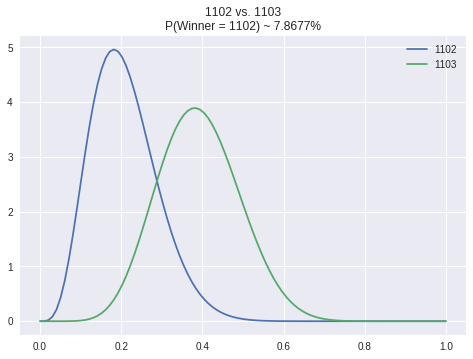

In [12]:
plot_odds(calc_odds(enumerate_matches(df_wins_losses_per_team)).iloc[0,:])

# Calculation of winning probability (Odds)
## Assumptions
* The probability of team A is winning against team B is winning is independent of the team combination, it just depends on the performance of each team against all the others
* We model a win of Team A if the probability of Team A is winning is greater than the probability of team B is winning
* The probability of a wrinning team is modelled by a beta distribution as described above

## Derviation of equation
We would like to calculate $$ P(A>B).$$ Based on the independence we can express the jopint distrubtion as $$P(A,B)=P(A)P(B)$$ and the integration boundaries as in the subsequent figure.
![derivation](../figures/01_Calculate_odds.jpg)
Which leads to the result $$P(A>B)=\int_0^1{f_B(b) \cdot [F_A(1) - F_A(b)]\,da\,db}$$ with the probability density functions $$f_A(a)=\textrm{Beta}(a; \alpha_A, \beta_A),$$ $$f_B(b)=\textrm{Beta}(b; \alpha_B, \beta_B)$$ and the cumulative probability density functions $$F_A(a)=\int_{-\infty}^a f_A(t)dt,$$ $$F_B(b)=\int_{-\infty}^b f_B(t)dt$$

In [17]:
df_wins_losses_per_team_enum = enumerate_matches(df_wins_losses_per_team)

In [40]:
def winning_probability(row):
    beta_a = beta(row["wins_a"], row["losses_a"])
    beta_b = beta(row["wins_b"], row["losses_b"])
    return quad(lambda b: beta_b.pdf(b) * (1 - beta_a.cdf(b)), 0, 1)[0]

In [41]:
df_wins_losses_per_team_enum.apply(winning_probability, axis=1)

0    0.078674
1    0.000086
2    0.053754
3    0.000025
4    0.010747
5    0.427901
6    0.003746
7    0.983728
8    0.301405
9    0.005803
dtype: float64